<a href="https://colab.research.google.com/github/ThisIsFarhan/SentimentAnalysis-PyTorch/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df = pd.read_csv("IMDB Dataset.csv")

In [16]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<Axes: xlabel='sentiment', ylabel='count'>

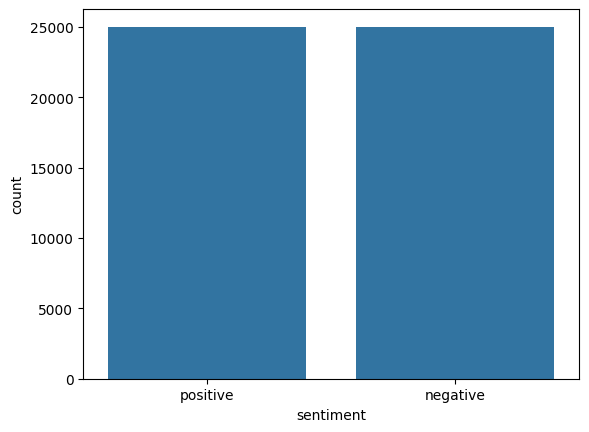

In [23]:
import seaborn as sns
sns.countplot(x='sentiment', data=df)

#Text Pre-Processing

In [18]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [20]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [24]:
X = []
sentences = list(df['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [25]:
y = df['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [29]:
print(len(X))
print(len(y))

50000
50000


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index)+1

In [32]:
from keras.preprocessing.sequence import pad_sequences
max_len = 100

X_train_seq = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test_seq = pad_sequences(X_test, padding='post', maxlen=max_len)

#Model

In [33]:
import torch
from torch.utils.data import DataLoader, Dataset

In [37]:
class CustomDataClass(Dataset):
  def __init__(self, X, y):
     self.X = torch.tensor(X, dtype=torch.long)  # Convert X to tensor if it's not already
     self.y = torch.tensor(y, dtype=torch.long)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, index):
      return self.X[index], self.y[index]

In [38]:
train_dataset = CustomDataClass(X_train_seq, y_train)
test_dataset = CustomDataClass(X_test_seq, y_test)

In [39]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
len(train_dataset)

40000

In [41]:
len(train_loader)

1250

In [45]:
import torch.nn as nn
class MyModel(nn.Module):
    def __init__(self, vocab_size):
       super().__init__()
       self.embedding = nn.Embedding(vocab_size, 64)
       self.rnn = nn.RNN(64, 50, batch_first=True)
       self.fc = nn.Linear(50, 2)

    def forward(self,review):
      embedded_review = self.embedding(review)
      hidden, final = self.rnn(embedded_review)
      output = self.fc(final.squeeze(0))
      return output

In [46]:
learning_rate = 0.001
epochs = 20
criterion = nn.CrossEntropyLoss()
model = MyModel(vocab_size)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [47]:
model.train()
for epoch in range(epochs):
    total_epoch_loss = 0
    correct = 0
    total = 0

    for review, feedback in train_loader:
        optimizer.zero_grad()
        op = model(review)  # Get raw model output (logits)

        loss = criterion(op, feedback)  # Compute loss
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

        # Calculate accuracy
        predicted = torch.argmax(op, dim=1)  # Convert logits to class predictions
        correct += (predicted == feedback).sum().item()  # Count correct predictions
        total += feedback.size(0)  # Total samples processed

    avg_loss = total_epoch_loss / len(train_loader)
    accuracy = (correct / total) * 100  # Accuracy percentage

    print(f'Epoch: {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch: 1, Loss: 0.6915, Accuracy: 52.31%
Epoch: 2, Loss: 0.6541, Accuracy: 58.23%
Epoch: 3, Loss: 0.6105, Accuracy: 62.42%
Epoch: 4, Loss: 0.5663, Accuracy: 66.98%
Epoch: 5, Loss: 0.5350, Accuracy: 71.83%
Epoch: 6, Loss: 0.5387, Accuracy: 66.36%
Epoch: 7, Loss: 0.4923, Accuracy: 72.57%
Epoch: 8, Loss: 0.4296, Accuracy: 79.88%
Epoch: 9, Loss: 0.4238, Accuracy: 78.84%
Epoch: 10, Loss: 0.3925, Accuracy: 83.54%
Epoch: 11, Loss: 0.3775, Accuracy: 83.14%
Epoch: 12, Loss: 0.3694, Accuracy: 83.75%
Epoch: 13, Loss: 0.3718, Accuracy: 83.43%
Epoch: 14, Loss: 0.4388, Accuracy: 70.68%
Epoch: 15, Loss: 0.4258, Accuracy: 71.84%
Epoch: 16, Loss: 0.3609, Accuracy: 82.49%
Epoch: 17, Loss: 0.3188, Accuracy: 87.21%
Epoch: 18, Loss: 0.3308, Accuracy: 86.34%
Epoch: 19, Loss: 0.3622, Accuracy: 82.01%
Epoch: 20, Loss: 0.3134, Accuracy: 87.27%


In [48]:
model.eval()

MyModel(
  (embedding): Embedding(92394, 64)
  (rnn): RNN(64, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

In [49]:
test_loss = 0
correct = 0
total = 0

with torch.no_grad():  # No gradient calculation
    for review, feedback in test_loader:
        op = model(review)  # Forward pass
        loss = criterion(op, feedback)  # Compute loss
        test_loss += loss.item()

        predicted = torch.argmax(op, dim=1)  # Convert logits to class labels
        correct += (predicted == feedback).sum().item()  # Count correct predictions
        total += feedback.size(0)  # Total samples

avg_test_loss = test_loss / len(test_loader)
test_accuracy = (correct / total) * 100  # Accuracy calculation

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.7308, Test Accuracy: 75.51%


In [58]:
review = ["So happy for the movie. its truly amazing"]
review_seq = tokenizer.texts_to_sequences(review)  # Convert text to sequences
print("Tokenized sequence:", review_seq)

review_seq = pad_sequences(review_seq, padding='post', maxlen=max_len)  # Pad sequence
print("Padded sequence:", review_seq)
review = torch.tensor(review_seq)
print(review.shape)
output = model(review)
print(output)
print(torch.argmax(output, dim=1))

Tokenized sequence: [[531, 1, 249, 367]]
Padded sequence: [[531   1 249 367   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
torch.Size([1, 100])
tensor([[-0.5492,  0.4491]], grad_fn=<AddmmBackward0>)
tensor([1])


In [59]:
review = ["Terrible movie did not like it at all"]
review_seq = tokenizer.texts_to_sequences(review)  # Convert text to sequences
print("Tokenized sequence:", review_seq)

review_seq = pad_sequences(review_seq, padding='post', maxlen=max_len)  # Pad sequence
print("Padded sequence:", review_seq)
review = torch.tensor(review_seq)
print(review.shape)
output = model(review)
print(output)
print(torch.argmax(output, dim=1))

Tokenized sequence: [[259, 1, 4]]
Padded sequence: [[259   1   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
torch.Size([1, 100])
tensor([[ 0.8250, -1.0041]], grad_fn=<AddmmBackward0>)
tensor([0])
